In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


#  Importing Data

In [3]:
#The images used will be an unstructured dataset, taken from a Kaggle public data source. 
#Creating variables for stadardization of the model.
batch_size = 64
img_height = 50
img_width = 50
#Implementing file path
file_path = "/kaggle/input/breast-histopathology-images/10254"
#Split data into training and validation sets
train = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=64
)

validation = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=64
)

Found 848 files belonging to 2 classes.
Using 679 files for training.
Found 848 files belonging to 2 classes.
Using 169 files for validation.


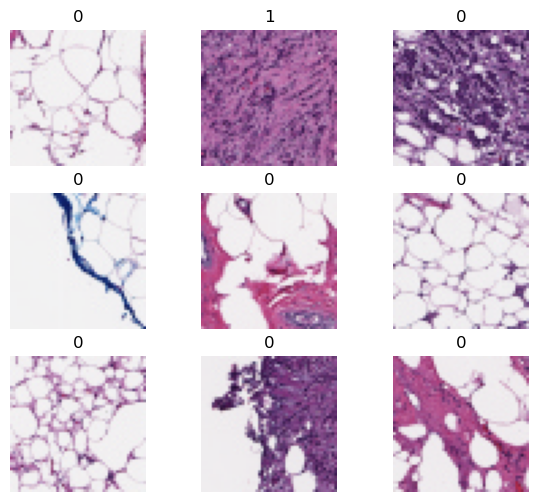

In [4]:
class_names = train.class_names
import matplotlib.pyplot as plt

#Image EDA to verify pictures and class labels
plt.figure(figsize=(7, 6))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#Batch and image size validation
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_val, labels_val in validation:
  print(image_val.shape)
  print(labels_val.shape)
  break

(64, 50, 50, 3)
(64,)
(64, 50, 50, 3)
(64,)


In [45]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Healthy', 'IDC']); ax.yaxis.set_ticklabels(['Healthy', 'IDC'])

# Logistic Regression test

In [7]:

#Training set manipulation into arrays for LogReg
image_array = np.array(image_batch, np.float32)
print(type(image_array))
label_array = np.array(labels_batch, np.float32)
print(type(label_array))
image_array = image_array.reshape(-1,7500)
label_array = label_array.reshape(-1,)
print(image_array.shape)
print(label_array.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(64, 7500)
(64,)


In [8]:
#Validation set manipulation into arrays for LogReg
val_image_array = np.array(image_val, np.float32)
print(type(val_image_array))
val_label_array = np.array(labels_val, np.float32)
print(type(val_label_array))
val_image_array = val_image_array.reshape(-1,7500)
val_label_array = val_label_array.reshape(-1,)
print(val_image_array.shape)
print(val_label_array.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(64, 7500)
(64,)


In [9]:
#LogReg model tuning and fit
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
lr.fit(image_array, label_array)

logreg_cv=GridSearchCV(lr, parameters, cv=4)
logreg_cv.fit(image_array, label_array)

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [10]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 1.0


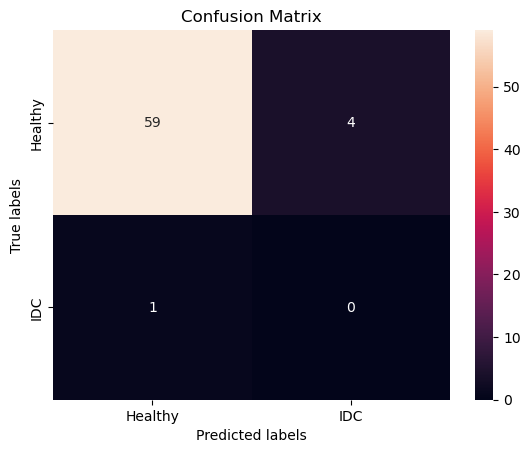

In [11]:
#Create a prediction from validation data
#Plot  using Confusion Matrix
Prediction=logreg_cv.predict(val_image_array)
plot_confusion_matrix(val_label_array,label_array)

# CNN Model creation and testing

In [12]:
#model creation
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2)
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
history = model.fit(
  train,
  validation_data=validation,
  epochs=15
)

Epoch 1/15
11/11 [==============================] - 3s 133ms/step - loss: 16.6238 - accuracy: 0.7909 - val_loss: 0.7271 - val_accuracy: 0.8580
Epoch 2/15
11/11 [==============================] - 1s 117ms/step - loss: 3.7938 - accuracy: 0.9013 - val_loss: 0.3631 - val_accuracy: 0.8935
Epoch 3/15
11/11 [==============================] - 1s 104ms/step - loss: 2.8584 - accuracy: 0.8351 - val_loss: 2.4788 - val_accuracy: 0.9231
Epoch 4/15
11/11 [==============================] - 1s 111ms/step - loss: 1.4045 - accuracy: 0.8895 - val_loss: 0.6858 - val_accuracy: 0.7574
Epoch 5/15
11/11 [==============================] - 2s 136ms/step - loss: 0.5541 - accuracy: 0.8984 - val_loss: 0.3102 - val_accuracy: 0.9053
Epoch 6/15
11/11 [==============================] - 1s 102ms/step - loss: 0.2886 - accuracy: 0.8999 - val_loss: 0.1981 - val_accuracy: 0.9408
Epoch 7/15
11/11 [==============================] - 2s 146ms/step - loss: 0.1809 - accuracy: 0.9367 - val_loss: 0.1857 - val_accuracy: 0.9349
Epoch

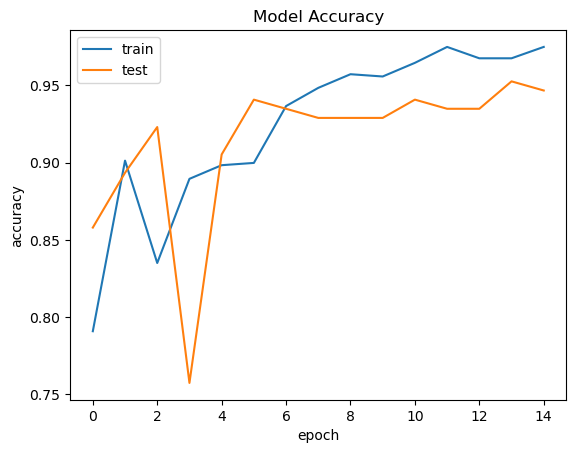

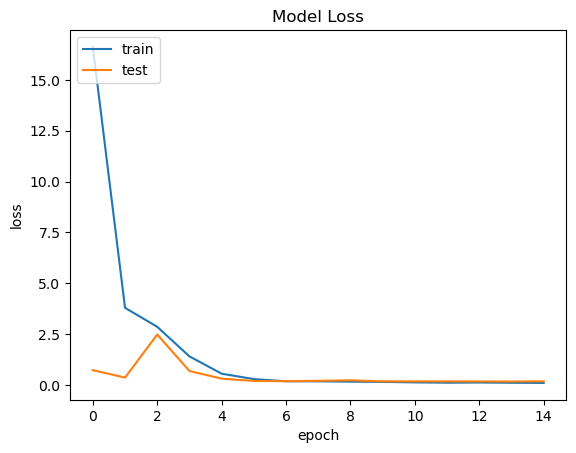

In [15]:
#Visualizing accuracy and loss for non normalized function
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
#Setting normalization of each image.
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.1137255 0.97647065


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
#Model creation
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
norm_history = model.fit(
  train,
  validation_data=validation,
  epochs=15
)

Epoch 1/15
11/11 [==============================] - 3s 119ms/step - loss: 0.3758 - accuracy: 0.8306 - val_loss: 0.2260 - val_accuracy: 0.9231
Epoch 2/15
11/11 [==============================] - 1s 101ms/step - loss: 0.2682 - accuracy: 0.9072 - val_loss: 0.2254 - val_accuracy: 0.9231
Epoch 3/15
11/11 [==============================] - 1s 98ms/step - loss: 0.2444 - accuracy: 0.9072 - val_loss: 0.2210 - val_accuracy: 0.9231
Epoch 4/15
11/11 [==============================] - 1s 98ms/step - loss: 0.2291 - accuracy: 0.9072 - val_loss: 0.2082 - val_accuracy: 0.9231
Epoch 5/15
11/11 [==============================] - 1s 97ms/step - loss: 0.1998 - accuracy: 0.9072 - val_loss: 0.2136 - val_accuracy: 0.9231
Epoch 6/15
11/11 [==============================] - 1s 94ms/step - loss: 0.1725 - accuracy: 0.9190 - val_loss: 0.1892 - val_accuracy: 0.9527
Epoch 7/15
11/11 [==============================] - 1s 100ms/step - loss: 0.1538 - accuracy: 0.9485 - val_loss: 0.1828 - val_accuracy: 0.9467
Epoch 8/15

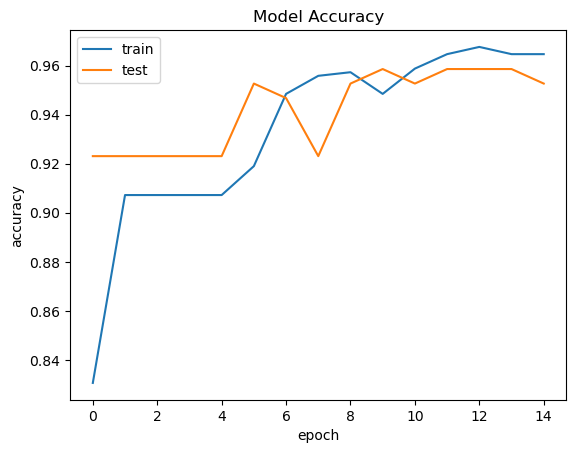

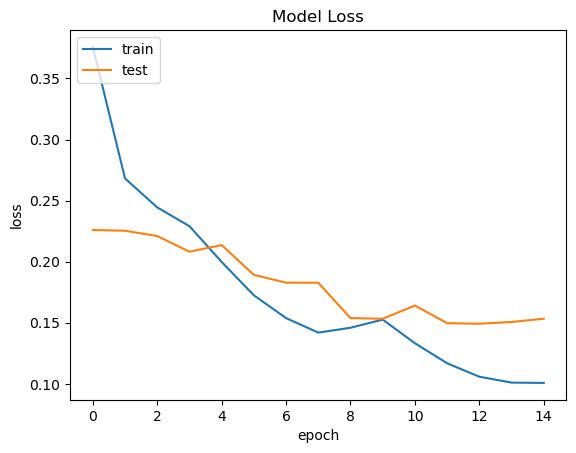

In [21]:
#Visualizing accuracy and loss functions for the normalized model.
plt.plot(norm_history.history['accuracy'])
plt.plot(norm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(norm_history.history['loss'])
plt.plot(norm_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading testing data and predicting results

Found 468 files belonging to 2 classes.
Using 375 files for training.
Found 468 files belonging to 2 classes.
Using 93 files for validation.
(64, 50, 50, 3)
(64,)
(64, 50, 50, 3)
(64,)


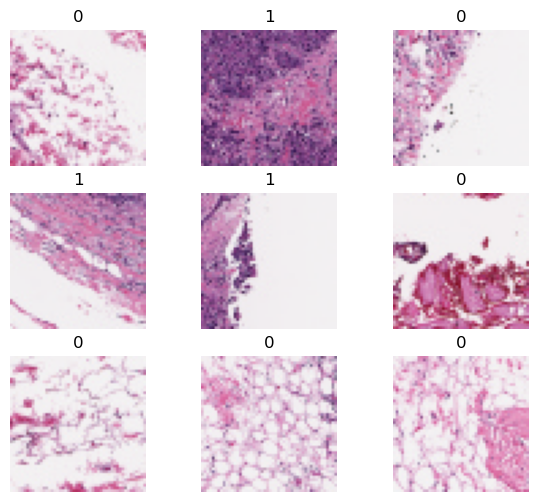

In [22]:
file_path = "/kaggle/input/breast-histopathology-images/10256"
#Split data into training and validation sets
test = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=64
)

test_val = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size = (img_height,img_width),
    batch_size=64
)

test_class_names = test.class_names

for image_test, labels_test in test:
  print(image_test.shape)
  print(labels_test.shape)
  break

for image_test_val, labels_test_val in validation:
  print(image_test_val.shape)
  print(labels_test_val.shape)
  break

#Image EDA to verify pictures and class labels
plt.figure(figsize=(7, 6))
for images, labels in test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_class_names[labels[i]])
    plt.axis("off")



2/2 [==============================] - 0s 16ms/step


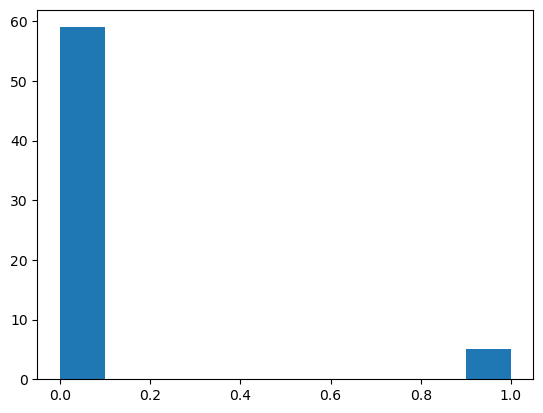

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:

predictions = model.predict(image_test_val)
pred_class = np.argmax(predictions, axis=1)
#true_class = np.argmax(labels_test_val)

plt.hist(pred_class)
plt.show()
pred_class

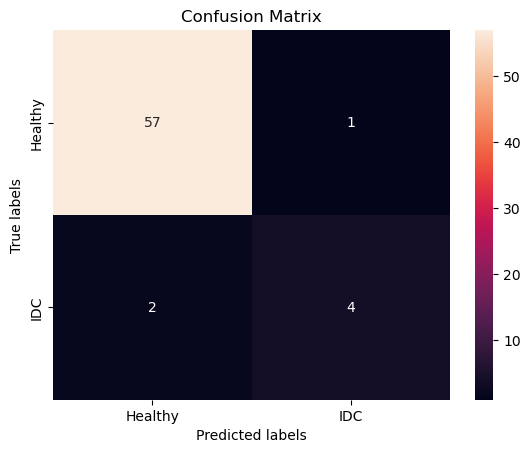

In [51]:
matrix = plot_confusion_matrix(labels_test_val, pred_class)